# Solution

## Goal
Derive and compute the maximum likelihood estimates (MLEs) of the mean and variance for i.i.d. data assumed to come from a Normal distribution.

## Problem Statement
How do you estimate the mean and variance using maximum likelihood estimation (MLE)?

## What you’ll see
- Likelihood vs. log-likelihood for i.i.d. samples
- Closed-form MLEs for the Normal model $(\mu,\sigma^2)$
- A numerical optimization sanity check
- A small simulation showing consistency (and the variance MLE’s small-sample bias)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Reproducibility
rng = np.random.default_rng(42)

plt.rcParams.update(
    {
        "figure.figsize": (8, 4.5),
        "axes.grid": True,
    }
)


def normal_loglik(x: np.ndarray, mu: float, sigma2: float) -> float:
    """Log-likelihood for i.i.d. Normal(mu, sigma2) observations."""
    if sigma2 <= 0:
        return -np.inf
    x = np.asarray(x)
    n = x.size
    return -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum((x - mu) ** 2) / sigma2


def mle_normal_closed_form(x: np.ndarray) -> tuple[float, float]:
    """Closed-form MLEs for Normal(mu, sigma2): (mu_hat, sigma2_hat)."""
    x = np.asarray(x)
    mu_hat = float(np.mean(x))
    sigma2_hat = float(np.mean((x - mu_hat) ** 2))  # note: divide by n
    return mu_hat, sigma2_hat

## Likelihood and log-likelihood (why we take logs)

If $X_1,\dots,X_n$ are i.i.d. with density (or pmf) $f(x\mid\theta)$, the likelihood is

$$
L(\theta) = \prod_{i=1}^n f(x_i\mid\theta).
$$

Because products can underflow and are harder to optimize, we maximize the **log-likelihood** instead:

$$
\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \log f(x_i\mid\theta).
$$

Maximizing $\ell(\theta)$ gives the same maximizer as maximizing $L(\theta)$ (log is monotone increasing).

## MLE for a Normal model: estimating $\mu$ and $\sigma^2$

Assume $X_1,\dots,X_n \overset{i.i.d.}{\sim} \mathcal{N}(\mu,\sigma^2)$.

The Normal pdf for one observation is

$$
f(x\mid \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).
$$

The log-likelihood for the full sample is

$$
\ell(\mu,\sigma^2) = -\frac{n}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^n (x_i-\mu)^2.
$$

### Solve for the maximizer

- Differentiate w.r.t. $\mu$ and set to zero:

$$
\frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2}\sum_{i=1}^n (x_i-\mu) = 0
\quad\Rightarrow\quad
\hat\mu_{\text{MLE}} = \bar x.
$$

- Plugging $\mu=\bar x$ back in and differentiating w.r.t. $\sigma^2$ yields:

$$
\hat\sigma^2_{\text{MLE}} = \frac{1}{n}\sum_{i=1}^n (x_i-\bar x)^2.
$$

**Important note:** $\hat\sigma^2_{\text{MLE}}$ divides by $n$ (not $n-1$). It is typically **biased downward** for finite $n$, but it is **consistent** as $n\to\infty$.

## Key pitfalls / practical notes

- **Work with log-likelihood**: products of many densities can underflow.
- **Constraint $\sigma^2>0$**: in numeric optimization, reparameterize with $\log\sigma^2$.
- **Variance MLE uses $1/n$**: it is typically *downward biased* for finite $n$.
- **Unbiased variance uses $1/(n-1)$**: common in descriptive statistics, but it’s not the Normal MLE.
- **Model mismatch matters**: if data are not close to Normal, the “best” Normal parameters may still fit poorly.

In [2]:
# Demonstration on one sample
mu_true = 2.0
sigma_true = 3.0
sigma2_true = sigma_true**2

n = 50
x = rng.normal(loc=mu_true, scale=sigma_true, size=n)

mu_hat, sigma2_hat = mle_normal_closed_form(x)

# Unbiased sample variance (not MLE) for comparison
sigma2_unbiased = float(np.var(x, ddof=1))

print(f"n = {n}")
print(f"True mu       = {mu_true:.4f}")
print(f"MLE mu_hat    = {mu_hat:.4f}")
print()
print(f"True sigma^2          = {sigma2_true:.4f}")
print(f"MLE sigma^2_hat (1/n) = {sigma2_hat:.4f}")
print(f"Unbiased s^2   (1/(n-1)) = {sigma2_unbiased:.4f}")
print()
print(f"Var MLE bias (this sample) = {sigma2_hat - sigma2_true:.4f}")

n = 50
True mu       = 2.0000
MLE mu_hat    = 2.2736

True sigma^2          = 9.0000
MLE sigma^2_hat (1/n) = 5.2060
Unbiased s^2   (1/(n-1)) = 5.3122

Var MLE bias (this sample) = -3.7940


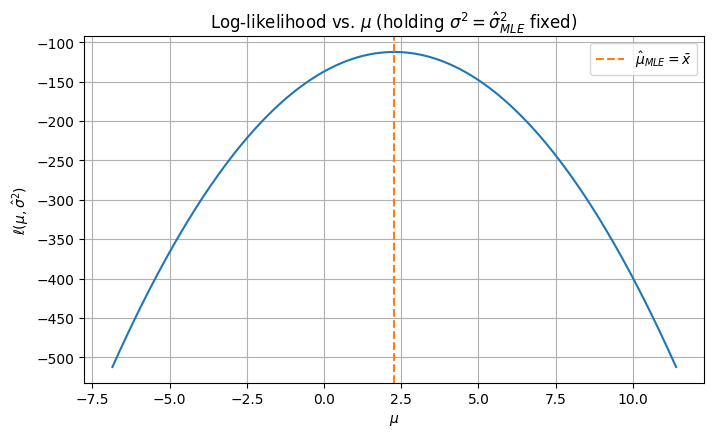

In [4]:
mu_grid = np.linspace(
    mu_hat - 4 * np.sqrt(sigma2_hat), mu_hat + 4 * np.sqrt(sigma2_hat), 300
)
ll_grid = np.array([normal_loglik(x, mu=m, sigma2=sigma2_hat) for m in mu_grid])

plt.plot(mu_grid, ll_grid)
plt.axvline(mu_hat, color="C1", linestyle="--", label=r"$\hat\mu_{MLE}=\bar x$")
plt.title(r"Log-likelihood vs. $\mu$ (holding $\sigma^2=\hat\sigma^2_{MLE}$ fixed)")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\ell(\mu,\hat\sigma^2)$")
plt.legend()
plt.show()

## Visual intuition: log-likelihood as a function of $\mu$

Holding $\sigma^2$ fixed, the log-likelihood is a concave quadratic in $\mu$, maximized at $\bar x$.

Below we plot $\ell(\mu,\sigma^2)$ over a grid of $\mu$ values (using $\sigma^2=\hat\sigma^2_{\text{MLE}}$).

## Numerical maximization sanity check (optional)

For the Normal model we have closed-form MLEs, but it’s useful to verify the result by directly maximizing the log-likelihood numerically.

To enforce $\sigma^2>0$, we optimize over $(\mu, \log\sigma^2)$ and convert back via $\sigma^2=\exp(\log\sigma^2)$.

In [5]:
def nll_params(params: np.ndarray, x: np.ndarray) -> float:
    mu = float(params[0])
    log_sigma2 = float(params[1])
    sigma2 = float(np.exp(log_sigma2))
    return -normal_loglik(x, mu=mu, sigma2=sigma2)


# Initialize near the closed-form solution
init_mu = mu_hat
init_log_sigma2 = float(np.log(max(sigma2_hat, 1e-12)))

res = minimize(
    nll_params, x0=np.array([init_mu, init_log_sigma2]), args=(x,), method="BFGS"
)
mu_num = float(res.x[0])
sigma2_num = float(np.exp(res.x[1]))

print("Optimization success:", bool(res.success))
print("Message:", res.message)
print()
print(f"Closed-form mu_hat   = {mu_hat:.6f}")
print(f"Numeric-opt mu_hat   = {mu_num:.6f}")
print()
print(f"Closed-form sigma2_hat = {sigma2_hat:.6f}")
print(f"Numeric-opt sigma2_hat = {sigma2_num:.6f}")
print()
print(f"Absolute diff in mu      = {abs(mu_hat - mu_num):.3e}")
print(f"Absolute diff in sigma2  = {abs(sigma2_hat - sigma2_num):.3e}")

Optimization success: True
Message: Optimization terminated successfully.

Closed-form mu_hat   = 2.273633
Numeric-opt mu_hat   = 2.273633

Closed-form sigma2_hat = 5.206004
Numeric-opt sigma2_hat = 5.206004

Absolute diff in mu      = 0.000e+00
Absolute diff in sigma2  = 8.882e-16


## Simulation: consistency and the variance MLE’s small-sample bias

For the Normal model:

- $\hat\mu_{\text{MLE}}=\bar X$ is unbiased for $\mu$.
- $\hat\sigma^2_{\text{MLE}}=\frac{1}{n}\sum_{i=1}^n (X_i-\bar X)^2$ is biased downward:

$$
\mathbb{E}[\hat\sigma^2_{\text{MLE}}] = \frac{n-1}{n}\,\sigma^2.
$$

But it is **consistent**: $\hat\sigma^2_{\text{MLE}}\to \sigma^2$ as $n\to\infty$.

Below we simulate many datasets for increasing $n$ and look at the average estimates.

Simulation results (means across repetitions)
n=  5 | E[mu_hat]≈ 1.9836 (true 2.0) | E[sigma2_hat]≈ 7.1354 | theory  7.2000 (true 9.0)
n= 10 | E[mu_hat]≈ 2.0091 (true 2.0) | E[sigma2_hat]≈ 8.1224 | theory  8.1000 (true 9.0)
n= 20 | E[mu_hat]≈ 2.0010 (true 2.0) | E[sigma2_hat]≈ 8.5280 | theory  8.5500 (true 9.0)
n= 50 | E[mu_hat]≈ 2.0011 (true 2.0) | E[sigma2_hat]≈ 8.8185 | theory  8.8200 (true 9.0)
n=100 | E[mu_hat]≈ 1.9962 (true 2.0) | E[sigma2_hat]≈ 8.9038 | theory  8.9100 (true 9.0)
n=500 | E[mu_hat]≈ 1.9999 (true 2.0) | E[sigma2_hat]≈ 8.9903 | theory  8.9820 (true 9.0)


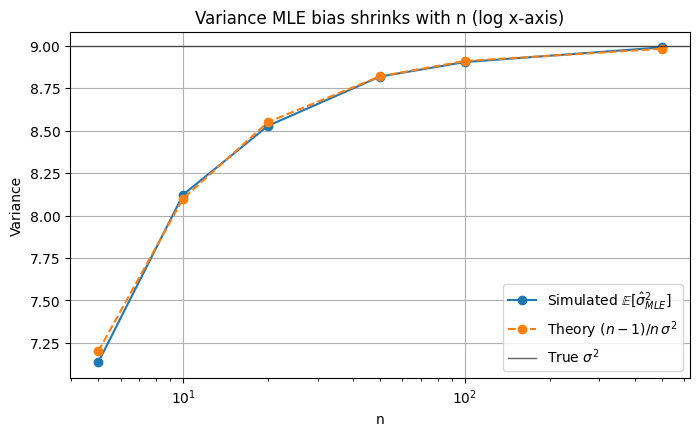

In [6]:
def simulate_mle_behavior(
    mu: float,
    sigma: float,
    n_values: list[int],
    reps: int = 5_000,
    seed: int = 123,
) -> dict[str, np.ndarray]:
    """Simulate MLE behavior for (mu, sigma^2) under a Normal model."""
    rg = np.random.default_rng(seed)
    sigma2 = sigma**2

    mu_hats = []
    sigma2_hats = []

    for n_i in n_values:
        x_sim = rg.normal(loc=mu, scale=sigma, size=(reps, n_i))
        mu_hat_i = np.mean(x_sim, axis=1)
        # MLE variance: average squared deviation from the sample mean, divide by n
        sigma2_hat_i = np.mean((x_sim - mu_hat_i[:, None]) ** 2, axis=1)

        mu_hats.append(mu_hat_i)
        sigma2_hats.append(sigma2_hat_i)

    mu_hats = np.vstack(mu_hats)  # shape: (len(n_values), reps)
    sigma2_hats = np.vstack(sigma2_hats)  # shape: (len(n_values), reps)

    return {
        "n": np.asarray(n_values, dtype=int),
        "mu_true": np.asarray(mu, dtype=float),
        "sigma2_true": np.asarray(sigma2, dtype=float),
        "mu_hat_mean": mu_hats.mean(axis=1),
        "mu_hat_sd": mu_hats.std(axis=1, ddof=1),
        "sigma2_hat_mean": sigma2_hats.mean(axis=1),
        "sigma2_hat_sd": sigma2_hats.std(axis=1, ddof=1),
        "sigma2_hat_theory_mean": (np.asarray(n_values, dtype=float) - 1.0)
        / np.asarray(n_values, dtype=float)
        * sigma2,
    }


n_values = [5, 10, 20, 50, 100, 500]
res_sim = simulate_mle_behavior(
    mu=mu_true, sigma=sigma_true, n_values=n_values, reps=10_000, seed=7
)

print("Simulation results (means across repetitions)")
for i, n_i in enumerate(res_sim["n"]):
    print(
        f"n={n_i:>3d} | "
        f"E[mu_hat]≈{res_sim['mu_hat_mean'][i]: .4f} (true {mu_true:.1f}) | "
        f"E[sigma2_hat]≈{res_sim['sigma2_hat_mean'][i]: .4f} | "
        f"theory {(res_sim['sigma2_hat_theory_mean'][i]): .4f} (true {sigma2_true:.1f})"
    )

# Plot convergence / bias visually
plt.plot(
    res_sim["n"],
    res_sim["sigma2_hat_mean"],
    marker="o",
    label=r"Simulated $\mathbb{E}[\hat\sigma^2_{MLE}]$",
)
plt.plot(
    res_sim["n"],
    res_sim["sigma2_hat_theory_mean"],
    marker="o",
    linestyle="--",
    label=r"Theory $(n-1)/n\,\sigma^2$",
)
plt.axhline(sigma2_true, color="k", linewidth=1, alpha=0.6, label=r"True $\sigma^2$")
plt.xscale("log")
plt.title("Variance MLE bias shrinks with n (log x-axis)")
plt.xlabel("n")
plt.ylabel(r"Variance")
plt.legend()
plt.show()

## Conclusion

- For i.i.d. Normal data, the MLEs are **closed-form**: $\hat\mu=\bar x$ and $\hat\sigma^2=\frac{1}{n}\sum (x_i-\bar x)^2$.
- The variance MLE is typically **biased downward** for finite samples, with $\mathbb{E}[\hat\sigma^2]=\frac{n-1}{n}\sigma^2$, but it is **consistent**.
- Numerical optimization (with a positivity-preserving parameterization) matches the closed-form solution and generalizes to models without analytic MLEs.